<a href="https://colab.research.google.com/github/alrz199/autoencoders/blob/main/contractive_autoencoder_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing contractive autoencoders using FashionMnist data

In [1]:
!pip --quiet install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 29.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import Accuracy

In [ ]:
batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor()])
# Fashion mnist
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

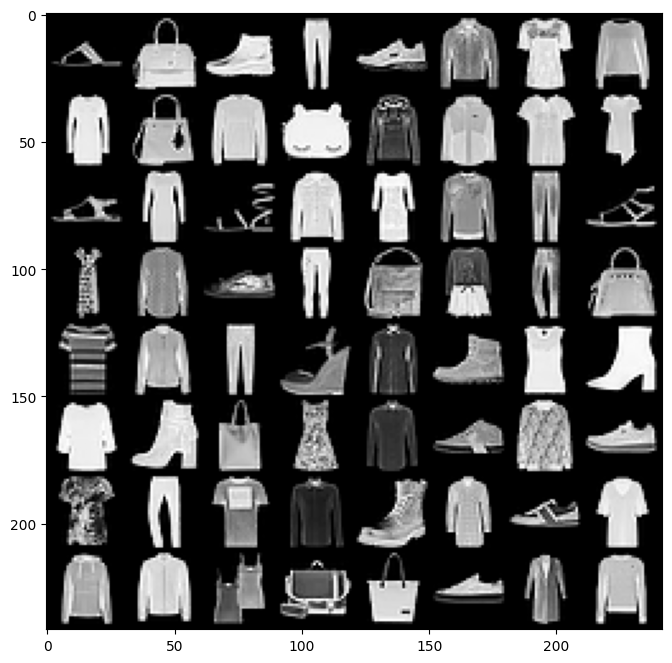

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# cae model
# there is a toturial for keras available at
# https://agustinus.kristia.de/techblog/2016/12/05/contractive-autoencoder/
import pytorch_lightning as pl
learning_rate=0.005
class nnn(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # If we are going to use the formula provided in the original paper,
        # we should use sigmoid as our activation function
        self.automatic_optimization = False
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 64),
            torch.nn.Sigmoid()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(64, 28*28)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        lam=0.001
        x, y = batch
        x = x.view(-1,28*28)
        h = self.encoder(x)
        out = self.decoder(h)
        loss = F.mse_loss(out,x)
        W=torch.t(self.state_dict()['encoder.0.weight'])
        dh = h * (1 - h)
        self.dh=dh
        self.W=W
        self.loss=loss
        contractive = lam * torch.sum(dh**2 * torch.sum(W**2, dim=0), dim=0)
        total_loss = loss + torch.sum(torch.abs(contractive))
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("train_loss", total_loss, prog_bar=True)
        adam, SGD = self.optimizers()
        adam.zero_grad()
        SGD.zero_grad()
        self.manual_backward(total_loss)
        adam.step()
        SGD.step()
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(-1,28*28)
        out=self.forward(x)
        loss = F.mse_loss(out,x)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # optimizer = [torch.optim.Adam(list(self.parameters())[0:1], lr=learning_rate),torch.optim.SGD(list(self.parameters())[1:], lr=learning_rate)]
        optimizer = [torch.optim.Adam(self.parameters(), lr=learning_rate)]
        return optimizer

In [ ]:
# Initialize a trainer
from pytorch_lightning import  Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="my_model")
model=nnn()
trainer = Trainer(
    accelerator="auto",
    max_epochs=10,callbacks=[EarlyStopping(monitor="val_loss")])

# Train the model ⚡
trainer.fit(model, train_loader,val_dataloaders=test_loader)
print('Finished Training')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.2 K
1 | decoder | Sequential | 51.0 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Finished Training


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/